# Test di Pearson

Il test di Pearson è un criterio di confronto non parametrico che ci consente di conoscere quale coppia di parametri $a$ e $b$ è quella che meglio descrive i dati a nostra disposizione.

La curva migliore è quella che suddivide i dati in degli intervalli, in un numero di elementi equivalenete sul suo dominio.

Il test consiste in:
1. Suddividere in 5 parti uguali il campo di probabilità (quantili)
2. Derivare una suddivisione del dominio in 5 intervalli
3. Contare il numero di dati per ogni intervallo
4. Valutare la funzione:
\begin{equation}
X^2=\sum_i^5 \frac{N_i - 22\cdot(P[H<h_{6}]-P[H<h_5])^2}{22\cdot(P[H<h_{6}]-P[H<h_5])}
\end{equation}

Con:
- Numero di misurazioni totali: $n = 22$
- Numero di intervalli: $j=5$
- Numero di dati in ciascun i-esimo intervallo: $N_i$.


In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

data = pd.read_csv('PluviometriaVE.txt')
map(datetime,data['anno'])
data=data.set_index('anno')

In [2]:
data

,1h,3h,6h,12h,24h
anno,,,,,
2000,36.2,36.2,62.0,73.2,93.2
2001,37.0,52.8,55.0,69.8,78.8
2002,41.8,55.4,58.2,59.0,60.0
2003,25.8,29.8,31.0,41.0,46.8
2004,21.2,28.0,39.0,45.6,61.6
2005,57.2,60.8,61.0,70.0,90.2
2006,36.0,50.4,57.4,93.6,109.2
2007,65.8,92.4,107.4,113.6,127.4
2008,47.2,49.4,59.6,89.8,102.2


In [3]:
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

Dopo aver scaricato le librerie necessarie, andiamo a leggere i file di dati contenenti le coppie di parametri $a$ e $b$, calcolate in precedenza col metodo dei momenti, il metodo dei minimi quadrati e il metodo della massima verosimiglianza. Riportiamo tali risultati in modo che sia subito possibile fare un confronto tra i risultati:

In [4]:
ab_m=pd.read_pickle("ab_m")
ab_mq=pd.read_pickle("ab_mq")
ab_mle=pd.read_pickle("ab_mle")

In [5]:
ab_m

,1h,3h,6h,12h,24h
a,31.831174,38.980308,45.614355,54.800484,64.499459
b,14.955350,19.358860,21.048080,21.119360,23.011086


In [6]:
ab_mq

,1h,3h,6h,12h,24h
a,29.837739,37.931925,44.927643,53.711052,63.239008
b,15.969347,17.954823,16.197238,18.276984,21.524754


In [7]:
ab_mle

,1h,3h,6h,12h,24h
a,31.724736,39.407941,46.548023,55.070815,64.518328
b,14.864016,16.922256,17.541655,19.266584,22.197209


Bisogna realizzare la curva di Gumbel con prefissati valori di $a$ e $b$.

Definiamo $rv$ come funzione di Gumbel, ma descritta attraverso i parametri di posizione (informazioni sulla moda) e di scala (legata alla deviazione standard).

In [8]:
rv=gumbel_r(loc=ab_m.at["a","1h"],scale=ab_m.at["b","1h"])

Per eseguire il test di Pearson, bisogna come prima operazione dividere in quantili il campo di probabilità (o dominio?).

A questo punto di deve calcolare la curva di probabilità relativa nei valori contraddistinti dai quantili.
Per fare questo viene definito $h1h$: il vettore che dà informazioni sull'inversa alla curva di Gumbel calcolata in un certo livello di probabilità.

In [9]:
q=[0.2,0.4,0.6,0.8,1]
h1h=rv.ppf(q)
h1h

array([24.71414766, 33.13859439, 41.87708632, 54.26330133,         inf])

Si nota infatti che il valore corrispondente a una probabilità pari a 1 è infinito.

Bisogna poi contare quanti elementi ci sono all'interno di ciascun intervallo utilizzando la funzione ECDF, in modo da eseguire il calcolo per ciascuno degli estremi superiori degli intervalli.

La variabile $r$ ci permette di costruire un vettore le cui componenti descrivono la percentuale di dati presenti prima di un certo valore. Ogni componente del vettore corrisponde a un quantile. 
Ad esempio, nel primo quantile la frazione di dati presente sarà pari al 0.227% del totale, fino alla fine del secondo avremo invece il 0.409% dei dati.

In [10]:
ecdf1h = ECDF(data["1h"])
r=ecdf1h(h1h)
r

array([0.22727273, 0.40909091, 0.63636364, 0.77272727, 1.        ])

Bisogna adesso confrontare la frazione di dati osservati con quelli attesi.
Cerchiamo innanzitutto i dati a nostra disposizione per ogni durata:

In [11]:
l1h=len(data["1h"])
l1h

22

Ci si aspetta che, in ogni $i$-esimo intervallo, con limite destro h1h, ci siano $e=(l1h * q)$ elementi mentre ce ne sono  in realtà $o=(l1h * r)$.  

La formula dell'$X^2$ è allora:
\begin{equation}
X^2 = \frac{1}{e}\sum_{i=1}^5 (e - o)^2
\end{equation}
Dove:
- $o$: valori osservati; 
- $e$: valori attesi; 

Applichiamo prima la formula per il calcolo del $X^2$ in modo manuale, per controllare poi che la funzione che introdurremo sia corretta.
A partire dalla frazione già calcolata, si può ottenere il numero (intero) di valori che troviamo effettivamente prima di un certo valore, in corrispondenza quindi dei vari intervalli.

In [12]:
o0=l1h*r
o0

array([ 5.,  9., 14., 17., 22.])

Per sapere poi quanti dati ci sono effettivamente per ogni intervallo introduciamo la seguente funzione che crea un vettore con i primi quattro valori uguali, ma preceduti da uno zero.

In [13]:
import numpy as np
np.append([0],np.delete(o0,-1))

array([ 0.,  5.,  9., 14., 17.])

Facciamo poi la differenza tra il vettore originale e il secondo vettore, appena introdotto, in modo da trovare il numero di valori osservati per ogni intervallo:

In [14]:
o=o0-np.append([0],np.delete(o0,-1))
o

array([5., 4., 5., 3., 5.])

In [15]:
range(len(r))

range(0, 5)

Essendoci 5 intervalli, si può trovare il numero di dati che ci dovrebbero essere per ogni intervallo se fossero distribuiti omogeneamente:

In [16]:
e=[0.2*l1h for i in range(len(r))]
e

[4.4, 4.4, 4.4, 4.4, 4.4]

Per calcolare poi $X^2$ basta applicare la formula riportata in precedenza:

In [17]:
((o-e)**2/e).sum()

0.7272727272727272

E' possibile poi ottenere lo stesso risultato dalla definizione della funzione $X2$, che tiene conto dei dati, del DataFrame che contiene i parametri, la colonna che ci interessa e il delta calcolato sulle ascisse (che prendiamo in questo caso sempre uguale):

In [18]:
def X2(data,abs_t,h,delta):    
    dt=data[h].dropna()
    lh=len(dt)
    q=[delta*(i+1) for i in range(int(1/delta))]
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    o0=lh*r
    o=o0-np.append([0],np.delete(o0,-1))
    e=[delta*lh for i in range(len(r))]
    return ((o-e)**2/e).sum()  

Il valore di $X^2$, calcolato per la durata di un'ora con i parametri trovati col metodo dei momenti è lo stesso che avevamo ricavato in precedenza, a conferma della correttezza delle operazioni:

In [19]:
X2(data,ab_m,"1h",0.2)

0.7272727272727272

In [20]:
X2(data,ab_mq,"1h",0.2)

0.7272727272727264

In [21]:
X2(data,ab_mle,"1h",0.2)

0.2727272727272727

Abbiamo quindi calcolato $X^2$ con i tre metodi per la durata di un'ora e notiamo che in questo caso il metodo migliore sarebbe quello della massima verosimiglianza:

In [22]:
data.columns

Index(['1h', '3h', '6h', '12h', '24h'], dtype='object')

Per semplificare i passaggi, si crea un ciclo for dove per ogni valore sulla colonna stampiamo $h$ e il valore di $X^2$ calcolato coi tre metodi per tutte le durate:

In [23]:
for  h in data.columns:
    print(h,": ",[X2(data,ab_m,h,0.2),X2(data,ab_mq,h,0.2),X2(data,ab_mle,h,0.2)])

1h :  [0.7272727272727272, 0.7272727272727264, 0.2727272727272727]
3h :  [4.818181818181819, 3.909090909090909, 3.000000000000002]
6h :  [2.5454545454545454, 2.5454545454545454, 1.1818181818181799]
12h :  [2.0909090909090904, 2.0909090909090904, 2.545454545454546]
24h :  [2.0909090909090926, 3.909090909090909, 2.0909090909090926]


# io credo che l'ultimo ciclo for si può togliere dato che la stessa operazione ma più completa viene fatta subito dopo

Per ogni durata scegliamo il caso migliore, che abbiamo infatti ottenuto con interpolazioni diverse.
Così facendo possiamo selezionare i parametri da utilizzare nell'analisi finale scegliendo quindi quelli con $X^2$ più piccolo.

Per costruire un data frame coi parametri migliori introduco intanto un vettore $a$ su cui inserisco i valori appena trovati:

In [24]:
a=[]
for  h in data.columns:
    a=a+[[X2(data,ab_m,h,0.2),X2(data,ab_mq,h,0.2),X2(data,ab_mle,h,0.2)]]
   
pd.DataFrame(a,index=["1h","3h","6h","12h","24h"],columns=["M","Mq","MLE"])

,M,Mq,MLE
1h,0.727273,0.727273,0.272727
3h,4.818182,3.909091,3.000000
6h,2.545455,2.545455,1.181818
12h,2.090909,2.090909,2.545455
24h,2.090909,3.909091,2.090909


Una volta individuati i valori minori possiamo creare manualmente la variabile $best$, che contiene i migliori parametri per le varie durate:


In [25]:
DatiT = data.T
DatiT.min()

anno
2000    36.2
2001    37.0
2002    41.8
2003    25.8
2004    21.2
2005    57.2
2006    36.0
2007    65.8
2008    47.2
2009    70.8
2010    47.6
2011    21.8
2012    19.0
2013    12.0
2014    74.2
2015    25.8
2016    38.6
2017    48.4
2018    20.8
2019    31.2
2020    80.0
2021    31.8
dtype: float64

In [26]:
best=pd.DataFrame([ab_mle["1h"],
                ab_mle["3h"],
                ab_mle["6h"],
                ab_mq["12h"],
                ab_m["24h"]]).T
                  
best

,1h,3h,6h,12h,24h
a,31.724736,39.407941,46.548023,53.711052,64.499459
b,14.864016,16.922256,17.541655,18.276984,23.011086


In [27]:
best.to_pickle("best_param")

In [28]:
def gumbel(x,ab_d,col):
    return np.exp(-np.exp(-(x-ab_d[col]["a"])/ab_d[col]["b"]))
t_rain=np.linspace(data.min()[0],data.max()[4],100)

Si ripetono quindi i passaggi seguiti anche negli altri casi per disegnare le curve che interpolano meglio i dati.
Questa volta i dati si scelgono dal DataFrame $best$.

Costruisco DataFrame con i dati da plottare:

In [29]:
gb=pd.DataFrame([gumbel(t_rain,best,"1h"),
                 gumbel(t_rain,best,"3h"),
                 gumbel(t_rain,best,"6h"),
                 gumbel(t_rain,best,"12h"),
                 gumbel(t_rain,best,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24"]
gb[-5:]

,1h,3h,6h,12h,24
12.000000,0.023057,0.006401,0.000772,0.000056,0.000056
13.424242,0.032539,0.009624,0.001349,0.000116,0.000101
14.848485,0.044497,0.014000,0.002259,0.000229,0.000175
16.272727,0.059133,0.019759,0.003633,0.000428,0.000294
17.696970,0.076568,0.027123,0.005631,0.000766,0.000479
...,...,...,...,...,...
147.303030,0.999580,0.998299,0.996802,0.994046,0.973004
148.727273,0.999619,0.998437,0.997051,0.994491,0.974604
150.151515,0.999653,0.998563,0.997281,0.994903,0.976109
151.575758,0.999685,0.998679,0.997493,0.995284,0.977527


In indice dal valore minimo al massimo in mm e la probabilità per ogni durata

Riusciamo infine a trovare il miglior risultato secondo il Test di Pearson:

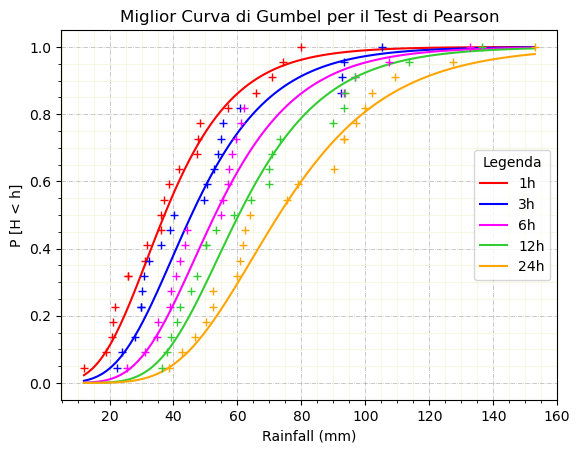

In [31]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.style.use('default')
ax=gb.plot(color=["red","blue","magenta","limegreen","orange"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'+',c="red", label="1h",markersize=6)
data3h=data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"+",c="blue", label="3h",markersize=6)
data6h=data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"+",c="magenta", label="6h",markersize=6)
data12h=data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"+",c="limegreen", label="12h",markersize=6)
data24h=data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"+",c="orange", label="24h",markersize=6)
ax.set_title('Miglior Curva di Gumbel per il Test di Pearson')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P [H < h]')
ax.set_aspect('auto')
plt.legend(['1h', '3h', '6h', '12h', '24h'], loc='right',  title = "Legenda", title_fontsize = 10)
#major grid lines
plt.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)
#minor grid lines
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='beige', alpha=0.8, ls='-', lw=0.8)
plt.show()


Queste sono le curve che danno il miglior test di Pearson.